In [ ]:
# %%

# 주의! ray를 pytorch보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import torch
import torch.nn as nn
import torch.nn.functional as F

import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 프로젝트 경로 설정
PROJECT_PATH = "/Users/gwanghunlee/Desktop/mpii"
IMAGE_PATH = os.path.join(PROJECT_PATH, 'data/images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
PT_RECORD_PATH = os.path.join(PROJECT_PATH, 'data/ptrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'data/mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'data/mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


In [ ]:
# %%

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [ ]:
# %%

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [ ]:
# %%

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/Users/gwanghunlee/Desktop/mpii/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [ ]:
# %%

def generate_ptexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일 읽기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    # JPEG 형식 및 RGB 모드가 아니면 변환
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0])
         for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0])
         for joint in anno['joints']]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height': height,
        'image/width': width,
        'image/depth': depth,
        'image/object/parts/x': x,
        'image/object/parts/y': y,
        'image/object/center/x': c_x,
        'image/object/center/y': c_y,
        'image/object/scale': scale,
        'image/object/parts/v': v,
        'image/encoded': content,
        'image/filename': filename.encode()  # bytes로 저장
    }

    return feature

print('슝=3')

슝=3


In [ ]:
# %%

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [ ]:
# %%

test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [ ]:
# %%

import pickle

@ray.remote
def build_single_ptrecord(chunk, path):
    print('start to build ptrecord for ' + path)

    with open(path, 'wb') as writer:
        for anno in chunk:
            ptexample = generate_ptexample(anno)
            pickle.dump(ptexample, writer)

    print('finished building ptrecord for ' + path)

print('슝=3')

슝=3


In [ ]:
# %%

def build_pt_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_ptrecord.remote(
            chunk, '{}/{}_{}_of_{}.ptrecords'.format(
                PT_RECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )
        ) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [ ]:
# %%

from torch.utils.data import Dataset

class MPIIDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # JSON 파일을 읽어 annotations 리스트 생성
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)

        # 각 annotation을 파싱하여 리스트에 저장
        self.annotations = [parse_one_annotation(anno, image_dir) for anno in annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # 이미지 파일 경로로부터 이미지를 로드 (RGB 모드로 변환)
        image = Image.open(anno['filepath']).convert('RGB')

        # transform이 있으면 적용
        if self.transform:
            image, heatmaps = self.transform({'image': image, 'annotation': anno})
            return image, heatmaps
        else:
            # transform이 없으면 원본 이미지와 annotation dict 반환
            return image, anno

In [ ]:
# %%time

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(PT_RECORD_PATH):
    os.makedirs(PT_RECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])

print('Start to build PT Records.')
build_pt_records(train_annotations, num_train_shards, 'train')
build_pt_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to PT Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-09-18 00:02:05,149	INFO worker.py:1951 -- Started a local Ray instance.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/Users/gwanghunlee/Desktop/mpii/data/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/Users/gwanghunlee/Desktop/mpii/data/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [11

(build_single_ptrecord pid=33062) finished building ptrecord for /Users/gwanghunlee/Desktop/mpii/data/ptrecords_mpii/val_0004_of_0008.ptrecords


In [ ]:
# %%

from tfrecord.torch.dataset import TFRecordDataset

feature_description = {
    'image/height': 'int',
    'image/width': 'int',
    'image/depth': 'int',
    'image/object/parts/x': 'int',
    'image/object/parts/y': 'int',
    'image/object/parts/v': 'int',
    'image/object/center/x': 'int',
    'image/object/center/y': 'int',
    'image/object/scale': 'float',
    'image/encoded': 'byte',
    'image/filename': 'byte',
}

print('슝=3')

슝=3


In [ ]:
# %%

import torch

def crop_roi(image, features, margin=0.2):
    img_height, img_width, img_depth = image.shape

    keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
    keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # 유효한 keypoint (값이 0보다 큰 값)만 선택합니다.
    masked_keypoint_x = keypoint_x[keypoint_x > 0]
    masked_keypoint_y = keypoint_y[keypoint_y > 0]

    # 최소, 최대 값 계산 (유효한 keypoint가 하나 이상 있다고 가정)
    keypoint_xmin = masked_keypoint_x.min()
    keypoint_xmax = masked_keypoint_x.max()
    keypoint_ymin = masked_keypoint_y.min()
    keypoint_ymax = masked_keypoint_y.max()

    # margin을 적용하여 경계를 확장 (body_height * margin 값을 정수로 캐스팅)
    extra = int(body_height * margin)
    xmin = int(keypoint_xmin.item()) - extra
    xmax = int(keypoint_xmax.item()) + extra
    ymin = int(keypoint_ymin.item()) - extra
    ymax = int(keypoint_ymax.item()) + extra

    # 이미지 경계를 벗어나지 않도록 조정
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height

    # 이미지 크기 재조정
    cropped_image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_height, new_width, _ = cropped_image.shape

    # keypoint 좌표를 정규화 (0~1 범위)
    effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

    return cropped_image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


In [ ]:
# %%

import torch

def generate_2d_gaussian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    # (height, width) 크기의 0으로 채워진 heatmap 생성
    heatmap = torch.zeros((height, width), dtype=torch.float32)

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma

    # 범위가 이미지 내에 없거나, visibility가 0이면 heatmap 그대로 반환
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = int(6 * sigma + 1)
    grid_range = torch.arange(0, size, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
    center_x = size // 2
    center_y = size // 2

    # 가우시안 patch 계산
    gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (sigma**2 * 2))) * scale

    # 이미지와 patch 간의 겹치는 영역 계산
    patch_xmin = max(0, -xmin)
    patch_ymin = max(0, -ymin)
    patch_xmax = min(xmax, width) - xmin
    patch_ymax = min(ymax, height) - ymin

    heatmap_xmin = max(0, xmin)
    heatmap_ymin = max(0, ymin)
    heatmap_xmax = min(xmax, width)
    heatmap_ymax = min(ymax, height)

    # 계산된 영역에 gaussian_patch 값을 할당
    heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
        gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
    x = torch.round(torch.tensor(keypoint_x, dtype=torch.float32) * heatmap_shape[0]).to(torch.int32)
    y = torch.round(torch.tensor(keypoint_y, dtype=torch.float32) * heatmap_shape[1]).to(torch.int32)

    num_heatmap = heatmap_shape[2]
    heatmaps_list = []
    for i in range(num_heatmap):
        # generate_2d_gaussian 함수 호출 시, height=heatmap_shape[1], width=heatmap_shape[0]
        gaussian = generate_2d_gaussian(
            heatmap_shape[1],
            heatmap_shape[0],
            int(y[i].item()),
            int(x[i].item()),
            visibility=int(v[i].item())
        )
        heatmaps_list.append(gaussian)

    # (num_heatmap, height, width) 텐서를 생성한 후, (height, width, num_heatmap)로 전치
    heatmaps = torch.stack(heatmaps_list, dim=0)
    heatmaps = heatmaps.permute(1, 2, 0)

    return heatmaps

print('슝=3')

슝=3


In [ ]:
# %%

import torch
from PIL import Image
import io
import numpy as np

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape      # (height, width, channels)
        self.heatmap_shape = heatmap_shape  # (height, width, num_heatmap)

    def __call__(self, example):
        features = self.parse_tfexample(example)
        # image 데이터를 다시 bytes로 디코딩 후 재로딩 (JPEG 형식)
        image = Image.open(io.BytesIO(features['image/encoded']))

        if self.is_train:
            # 0.1 ~ 0.3 사이의 random margin 생성
            random_margin = torch.empty(1).uniform_(0.1, 0.3).item()
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = image.resize((self.image_shape[1], self.image_shape[0]))
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = image.resize((self.image_shape[1], self.image_shape[0]))

        # 이미지 정규화: uint8 → [0,255] → [-1, 1]
        image_np = np.array(image).astype(np.float32)
        image_np = image_np / 127.5 - 1.0
        # 채널 우선순서로 변환: (H, W, C) -> (C, H, W)
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image_tensor, heatmaps

    def parse_tfexample(self, example):
        """
        MPIIDataset에서 전달한 예제를 받아, Preprocessor가 처리할 수 있도록 features dict를 구성합니다.
        예제 형식: {'image': PIL.Image, 'annotation': anno}
        """
        annotation = example['annotation']
        # joints: list of [x, y]
        joints = annotation['joints']
        keypoint_x = [joint[0] for joint in joints]
        keypoint_y = [joint[1] for joint in joints]

        # joints_vis가 없으면 모든 관절이 가시적이라고 가정 (1)
        joints_vis = annotation.get('joints_vis', [1] * len(joints))

        features = {
            'image/encoded': self.image_to_bytes(example['image']),
            'image/object/parts/x': keypoint_x,
            'image/object/parts/y': keypoint_y,
            'image/object/parts/v': joints_vis,
            'image/object/center/x': annotation['center'][0],
            'image/object/center/y': annotation['center'][1],
            'image/object/scale': annotation['scale'],
        }
        return features

    def image_to_bytes(self, image):
        """
        PIL.Image 객체를 JPEG 인코딩된 bytes로 변환합니다.
        """
        buffer = io.BytesIO()
        image.save(buffer, format="JPEG")
        return buffer.getvalue()

    def crop_roi(self, image, features, margin=0.2):
        # image: PIL.Image, features: dict
        img_width, img_height = image.size  # PIL: (width, height)

        keypoint_x = torch.tensor(features['image/object/parts/x'], dtype=torch.int32)
        keypoint_y = torch.tensor(features['image/object/parts/y'], dtype=torch.int32)
        body_height = features['image/object/scale'] * 200.0

        # 유효한 keypoint (값 > 0)만 선택
        masked_keypoint_x = keypoint_x[keypoint_x > 0]
        masked_keypoint_y = keypoint_y[keypoint_y > 0]

        keypoint_xmin = int(masked_keypoint_x.min().item())
        keypoint_xmax = int(masked_keypoint_x.max().item())
        keypoint_ymin = int(masked_keypoint_y.min().item())
        keypoint_ymax = int(masked_keypoint_y.max().item())

        extra = int(body_height * margin)
        xmin = keypoint_xmin - extra
        xmax = keypoint_xmax + extra
        ymin = keypoint_ymin - extra
        ymax = keypoint_ymax + extra

        effective_xmin = max(xmin, 0)
        effective_ymin = max(ymin, 0)
        effective_xmax = min(xmax, img_width)
        effective_ymax = min(ymax, img_height)

        cropped_image = image.crop((effective_xmin, effective_ymin, effective_xmax, effective_ymax))

        new_width = effective_xmax - effective_xmin
        new_height = effective_ymax - effective_ymin

        effective_keypoint_x = (keypoint_x.float() - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y.float() - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        heatmap = torch.zeros((height, width), dtype=torch.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = int(6 * sigma + 1)
        grid_range = torch.arange(0, size, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(grid_range, grid_range, indexing='xy')
        center_x = size // 2
        center_y = size // 2

        gaussian_patch = torch.exp(-(((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))) * scale

        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        heatmap_xmin = max(0, xmin)
        heatmap_ymin = max(0, ymin)
        heatmap_xmax = min(xmax, width)
        heatmap_ymax = min(ymax, height)

        heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
            gaussian_patch[int(patch_ymin):int(patch_ymax), int(patch_xmin):int(patch_xmax)]

        return heatmap

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        # heatmap_shape: (height, width, num_heatmap)
        v = torch.tensor(features['image/object/parts/v'], dtype=torch.float32)
        x = torch.round(keypoint_x * heatmap_shape[1]).to(torch.int32)  # width: heatmap_shape[1]
        y = torch.round(keypoint_y * heatmap_shape[0]).to(torch.int32)  # height: heatmap_shape[0]

        num_heatmap = heatmap_shape[2]
        heatmaps_list = []

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(
                height=heatmap_shape[0],
                width=heatmap_shape[1],
                y0=int(y[i].item()),
                x0=int(x[i].item()),
                visibility=int(v[i].item())
            )
            heatmaps_list.append(gaussian)

        # 스택 후, (num_heatmap, height, width) 형태로 반환
        heatmaps = torch.stack(heatmaps_list, dim=0)
        return heatmaps

print('슝=3')

슝=3


In [ ]:
# %%

import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        # 만약 downsample이라면 identity branch에 1x1 conv 적용하여 채널 수와 spatial size 조정
        if self.downsample:
            self.downsample_conv = nn.Conv2d(in_channels, filters, kernel_size=1, stride=stride, bias=False)

        # main branch
        self.bn1 = nn.BatchNorm2d(in_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, filters // 2, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        # kernel_size=3, padding=1로 'same' padding 효과
        self.conv2 = nn.Conv2d(filters // 2, filters // 2, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(filters // 2, momentum=0.9)
        self.conv3 = nn.Conv2d(filters // 2, filters, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample_conv(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out += identity
        return out

print('슝=3')

슝=3


In [ ]:
# %%

import torch
import torch.nn as nn

class HourglassModule(nn.Module):
    def __init__(self, order, filters, num_residual):
        super(HourglassModule, self).__init__()
        self.order = order

        # Up branch: BottleneckBlock 1회 + num_residual회 반복
        self.up1_0 = BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
        self.up1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Low branch: MaxPool + num_residual BottleneckBlock
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # Recursive hourglass or additional BottleneckBlocks
        if order > 1:
            self.low2 = HourglassModule(order - 1, filters, num_residual)
        else:
            self.low2_blocks = nn.Sequential(*[
                BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
                for _ in range(num_residual)
            ])

        # 후처리 BottleneckBlock 반복
        self.low3_blocks = nn.Sequential(*[
            BottleneckBlock(in_channels=filters, filters=filters, stride=1, downsample=False)
            for _ in range(num_residual)
        ])

        # UpSampling (최근접 보간법)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # up branch
        up1 = self.up1_0(x)
        up1 = self.up1_blocks(up1)

        # low branch
        low1 = self.pool(x)
        low1 = self.low1_blocks(low1)
        if self.order > 1:
            low2 = self.low2(low1)
        else:
            low2 = self.low2_blocks(low1)
        low3 = self.low3_blocks(low2)
        up2 = self.upsample(low3)

        return up2 + up1

print('슝=3')

슝=3


In [ ]:
# %%

import torch
import torch.nn as nn

class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # He (Kaiming) 초기화 적용
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

print('슝=3')

슝=3


In [ ]:
# %%

import torch
import torch.nn as nn

class StackedHourglassNetwork(nn.Module):
    def __init__(self, input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stack = num_stack

        in_channels = input_shape[2]  # 3
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck blocks 초기화
        # BottleneckBlock의 첫번째 호출: 64 → 128, downsample=True
        self.bottleneck1 = BottleneckBlock(in_channels=64, filters=128, stride=1, downsample=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째: 128 → 128, downsample=False
        self.bottleneck2 = BottleneckBlock(in_channels=128, filters=128, stride=1, downsample=False)
        # 세 번째: 128 → 256, downsample=True
        self.bottleneck3 = BottleneckBlock(in_channels=128, filters=256, stride=1, downsample=True)

        # 스택 구성 요소들
        self.hourglass_modules = nn.ModuleList()
        self.residual_modules = nn.ModuleList()  # hourglass 후 residual block들 (num_residual회)
        self.linear_layers = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        # 마지막 스택을 제외한 중간 피쳐 결합용 1x1 conv
        self.intermediate_convs = nn.ModuleList()
        self.intermediate_outs = nn.ModuleList()

        for i in range(num_stack):
            # order=4인 hourglass 모듈 (앞에서 정의한 HourglassModule 사용)
            self.hourglass_modules.append(HourglassModule(order=4, filters=256, num_residual=num_residual))
            # hourglass 후 residual block들
            self.residual_modules.append(nn.Sequential(*[
                BottleneckBlock(in_channels=256, filters=256, stride=1, downsample=False)
                for _ in range(num_residual)
            ]))
            # Linear layer: 1x1 conv + BN + ReLU (앞에서 정의한 LinearLayer 사용)
            self.linear_layers.append(LinearLayer(in_channels=256, out_channels=256))
            # 최종 heatmap을 생성하는 1x1 conv
            self.heatmap_convs.append(nn.Conv2d(256, num_heatmap, kernel_size=1, stride=1, padding=0))

            if i < num_stack - 1:
                self.intermediate_convs.append(nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.intermediate_outs.append(nn.Conv2d(num_heatmap, 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.bottleneck1(x)
        x = self.pool(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)

        outputs = []
        for i in range(self.num_stack):
            hg = self.hourglass_modules[i](x)
            res = self.residual_modules[i](hg)
            lin = self.linear_layers[i](res)
            heatmap = self.heatmap_convs[i](lin)
            outputs.append(heatmap)

            if i < self.num_stack - 1:
                inter1 = self.intermediate_convs[i](lin)
                inter2 = self.intermediate_outs[i](heatmap)
                x = inter1 + inter2  # 다음 스택의 입력으로 사용

        return outputs

print('슝=3')

슝=3


In [ ]:
# %%

import os
import math
import torch
import torch.nn as nn
import torch.optim as optim

class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 initial_learning_rate):
        """
        - model: 학습시킬 PyTorch 모델(nn.Module)
        - epochs: 전체 학습 epoch 수
        - global_batch_size: 전체 배치 크기 (loss 계산 시 사용)
        - initial_learning_rate: 초기 학습률
        """
        self.model = model
        self.epochs = epochs
        self.global_batch_size = global_batch_size

        # MSE loss를 reduction='none'으로 사용 (가중치 적용을 위해)
        self.loss_object = nn.MSELoss(reduction='none')

        # Adam optimizer 초기화
        self.optimizer = optim.Adam(self.model.parameters(), lr=initial_learning_rate)

        # 학습률 스케줄링 관련 변수들
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10

        # 최적 모델 체크포인트 저장
        self.best_model = None

        # 단일 GPU/멀티 GPU(DataParallel) 설정
        # Apple의 mps(Metal Performance Shaders) GPU를 사용할 수 있는지 확인하고, 
        # 가능하다면 mps 디바이스로 모델을 이동시킵니다.
        # 그렇지 않으면 CPU에 모델을 둡니다.
        if torch.backends.mps.is_available():
            print("Apple MPS(GPU) 사용")
            self.model = self.model.to('mps')
        else:
            print("Apple MPS(GPU) 미지원 - CPU 사용")
            self.model = self.model.to('cpu')

    def lr_decay(self):
        """
        patience_count가 max_patience를 넘으면 학습률을 1/10으로 감소,
        그렇지 않고 val_loss가 그대로면 patience_count += 1,
        새 최저 val_loss를 달성하면 patience_count를 0으로.
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0

        self.patience_count += 1

        # optimizer의 learning rate 갱신
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """
        25, 50, 75 epoch에서 학습률을 1/10으로 감소시키는 스케줄링.
        """
        if epoch in [25, 50, 75]:
            self.current_learning_rate /= 10.0

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        여러 스택의 heatmap 출력(outputs)에 대해 MSE를 구하되,
        labels > 0인 위치에는 81의 추가 가중치를 적용.
        """
        loss = 0
        for output in outputs:
            # labels > 0 이면 81 + 1 = 82, 아니면 1
            weights = (labels > 0).float() * 81 + 1
            squared_error = (labels - output) ** 2
            weighted_error = squared_error * weights
            # 전체 배치에 대한 평균 후, global_batch_size로 나눔
            loss += weighted_error.mean() / self.global_batch_size
        return loss

    def train_step(self, images, labels, device):
        self.model.train()
        images = images.to(device)
        labels = labels.to(device)

        self.optimizer.zero_grad()
        outputs = self.model(images)
        loss = self.compute_loss(labels, outputs)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def val_step(self, images, labels, device):
        self.model.eval()
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.compute_loss(labels, outputs)
        return loss.item()

    def run(self, train_loader, val_loader, device):
        """
        - train_loader, val_loader: PyTorch DataLoader
        - device: torch.device('cuda' or 'cpu')
        """
        for epoch in range(1, self.epochs + 1):
            # 학습률 감소 로직
            self.lr_decay()
            print(f"Start epoch {epoch} with learning rate {self.current_learning_rate:.6f}")

            # Training
            total_train_loss = 0.0
            num_train_batches = 0
            for images, labels in train_loader:
                batch_loss = self.train_step(images, labels, device)
                total_train_loss += batch_loss
                num_train_batches += 1
                print(f"[Train] batch {num_train_batches} loss {batch_loss:.4f} "
                      f"avg_loss {total_train_loss/num_train_batches:.4f}")
            train_loss = total_train_loss / num_train_batches
            print(f"Epoch {epoch} train loss {train_loss:.4f}")

            # Validation
            total_val_loss = 0.0
            num_val_batches = 0
            for images, labels in val_loader:
                batch_loss = self.val_step(images, labels, device)
                num_val_batches += 1
                print(f"[Val] batch {num_val_batches} loss {batch_loss:.4f}")
                # NaN이 아닌 경우만 합산
                if not math.isnan(batch_loss):
                    total_val_loss += batch_loss
                else:
                    num_val_batches -= 1

            if num_val_batches > 0:
                val_loss = total_val_loss / num_val_batches
            else:
                val_loss = float('nan')

            print(f"Epoch {epoch} val loss {val_loss:.4f}")

            # 새로운 최저 val_loss 달성 시 모델 저장
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = os.path.join(MODEL_PATH, f'model-epoch-{epoch}-loss-{loss:.4f}.pt')
        torch.save(self.model.state_dict(), model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")

print('슝=3')

슝=3


In [ ]:
# %%

from torch.utils.data import DataLoader

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataloader(annotation_file, image_dir, batch_size, num_heatmap, is_train=True):
    """
    annotation_file: JSON 파일 경로 (예: train.json)
    image_dir: 이미지 파일들이 저장된 디렉토리 경로
    batch_size: 배치 크기
    num_heatmap: 생성할 heatmap 개수
    is_train: True이면 shuffle 적용
    """

    preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap),
        is_train=is_train
    )

    dataset = MPIIDataset(annotation_file=annotation_file, image_dir=image_dir, transform=preprocess)

    # DataLoader 생성
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        prefetch_factor=2
    )

    return dataloader

In [ ]:
# %%

def train(epochs, learning_rate, num_heatmap, batch_size, train_annotation_file, val_annotation_file, image_dir):
    """
    - epochs: 전체 학습 epoch 수
    - learning_rate: 초기 학습률
    - num_heatmap: 생성할 heatmap 개수
    - batch_size: 배치 크기
    - train_annotation_file: train.json 파일 경로
    - val_annotation_file: validation.json 파일 경로
    - image_dir: 이미지 파일들이 저장된 디렉토리 경로
    """
    global_batch_size = batch_size

    train_loader = create_dataloader(train_annotation_file, image_dir, batch_size, num_heatmap, is_train=True)
    val_loader = create_dataloader(val_annotation_file, image_dir, batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainer = Trainer(
        model,
        epochs,
        global_batch_size,
        initial_learning_rate=learning_rate
    )

    print("Start training...")
    return trainer.run(train_loader, val_loader, device)

print('슝=3')

슝=3


In [ ]:
# %%

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-epoch-2-loss-1.2050.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
model.to(device)
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval() # 평가 모드로 변경

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
# model.to(device)
# checkpoint = torch.load(best_model_file, map_location=device)
# model.load_state_dict(checkpoint)
# model.eval()

StackedHourglassNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (bottleneck1): BottleneckBlock(
    (downsample_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck2

In [ ]:
# %%

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [ ]:
# %%

import gdown

file_id = "1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ"
output_path = "model-epoch-2-loss-1.2050.pt"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
#!mv model-epoch-2-loss-1.2050.pt /Users/gwanghunlee/Desktop/mpii/models

# ViTPose 파인튜닝 부분과 동일하게 하이퍼파라미터를 정의합니다.
# epochs: 전체 학습 반복 횟수
# batch_size: 한 번에 처리할 데이터 샘플 수
# num_heatmap: 예측할 관절(키포인트) 수 (MPII 기준 16개)
# learning_rate: 최적화에 사용할 학습률
epochs = 5
batch_size = 2
num_heatmap = 16
learning_rate = 0.0007

Downloading...
From (original): https://drive.google.com/uc?id=1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ
From (redirected): https://drive.google.com/uc?id=1-F6ztKRSL7Lp0kVT7nPuSIfEpBWz1abZ&confirm=t&uuid=b67a4f7b-d050-449f-8804-26945c28cbf3
To: /Users/gwanghunlee/Desktop/mpii/model-epoch-2-loss-1.2050.pt
100%|██████████| 65.9M/65.9M [00:02<00:00, 25.2MB/s]


In [ ]:
# %%

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-epoch-2-loss-1.2050.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
model.to(device)
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval() # 평가 모드로 변경

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=num_heatmap)
# model.to(device)
# checkpoint = torch.load(best_model_file, map_location=device)
# model.load_state_dict(checkpoint)
# model.eval()

StackedHourglassNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (bottleneck1): BottleneckBlock(
    (downsample_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck2

In [ ]:
# %%

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [ ]:
# %%

def find_max_coordinates(heatmaps):
    # heatmaps: (H, W, C)
    H, W, C = heatmaps.shape
    # reshape to (H*W, C)
    flatten_heatmaps = heatmaps.reshape(-1, C)
    # 각 채널 별 최대값 인덱스 (flattened index)
    indices = torch.argmax(flatten_heatmaps, dim=0)
    # y 좌표: index // H, x 좌표: index - H * y
    y = indices // H
    x = indices - H * y
    # 반환: (C, 2) 텐서, 각 행이 [x, y] 좌표
    return torch.stack([x, y], dim=1)
print("슝=3")

슝=3


In [ ]:
# %%

def extract_keypoints_from_heatmap(heatmaps):
    """
    heatmaps: (H, W, C) 텐서 (예: (64,64,16))
    """
    H, W, C = heatmaps.shape
    max_keypoints = find_max_coordinates(heatmaps)  # shape: (C, 2) with [x, y] per channel

    # pad heatmaps: 먼저 (C, H, W)로 변환한 후 pad, 다시 (H+2, W+2, C)
    heatmaps_permuted = heatmaps.permute(2, 0, 1)  # (C, H, W)
    padded = F.pad(heatmaps_permuted, (1, 1, 1, 1))  # pad (left, right, top, bottom)
    padded_heatmaps = padded.permute(1, 2, 0)  # (H+2, W+2, C)

    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # 기존 keypoint의 좌표에 패딩 오프셋 추가
        max_x = int(keypoint[0].item()) + 1
        max_y = int(keypoint[1].item()) + 1

        # 3x3 패치를 추출 (채널 i)
        patch = padded_heatmaps[max_y-1:max_y+2, max_x-1:max_x+2, i]  # (3,3)
        # 중앙 값 제거
        patch[1, 1] = 0
        # 패치 내 최대값의 index를 찾음
        flat_patch = patch.reshape(-1)
        index = torch.argmax(flat_patch).item()

        next_y = index // 3
        next_x = index % 3
        delta_y = (next_y - 1) / 4.0
        delta_x = (next_x - 1) / 4.0

        adjusted_x = keypoint[0].item() + delta_x
        adjusted_y = keypoint[1].item() + delta_y
        adjusted_keypoints.append((adjusted_x, adjusted_y))

    # 리스트를 텐서로 변환하고 clip
    adjusted_keypoints = torch.tensor(adjusted_keypoints)
    adjusted_keypoints = torch.clamp(adjusted_keypoints, 0, H)
    normalized_keypoints = adjusted_keypoints / H
    return normalized_keypoints

print('슝=3')

슝=3


In [ ]:
# %%

import torch
from PIL import Image
import torchvision.transforms as transforms

def predict(model, image_path):
    # 이미지 로드 (RGB 모드)
    image = Image.open(image_path).convert("RGB")

    # 전처리: 리사이즈, 텐서 변환, [-1, 1] 범위로 스케일링
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),         # 결과: [0, 1]
        transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
    ])
    inputs = preprocess(image)          # shape: (C, H, W)
    inputs = inputs.unsqueeze(0)        # 배치 차원 추가: (1, C, H, W)

    # 모델의 device에 맞게 입력을 이동시킵니다.
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs)         # outputs가 리스트가 아닐 수 있음

    if not isinstance(outputs, list):
        outputs = [outputs]

    # 마지막 스택의 결과를 사용한다고 가정 (출력 shape: (1, num_heatmap, H, W))
    heatmap_tensor = outputs[-1].squeeze(0)      # (num_heatmap, H, W)
    # extract_keypoints_from_heatmap 함수는 (H, W, num_heatmap) 형태를 기대하므로 차원 순서를 변경
    heatmap_tensor = heatmap_tensor.permute(1, 2, 0)  # (H, W, num_heatmap)

    # detach, CPU로 이동 후 extract_keypoints_from_heatmap에 전달
    heatmap = heatmap_tensor.detach().cpu()
    kp = extract_keypoints_from_heatmap(heatmap)

    return image, kp

print('슝=3')

슝=3


In [ ]:
# %%

import torch
import numpy as np
import matplotlib.pyplot as plt

def to_numpy_image(image):
    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        # 이미지 채널이 첫 번째 차원이라면, (C, H, W) -> (H, W, C)
        if image_np.ndim == 3 and image_np.shape[0] == 3:
            image_np = np.transpose(image_np, (1, 2, 0))
    elif not isinstance(image, np.ndarray):
        # PIL.Image인 경우
        image_np = np.array(image)
    else:
        image_np = image
    return image_np

def draw_keypoints_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        if index is not None and index != i:
            continue
        ax.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    image_np = to_numpy_image(image)

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image_np.shape[1]
        joint_y = joint[1] * image_np.shape[0]
        joints.append((joint_x, joint_y))

    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        ax.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


In [ ]:
# %%

# 기본 제공 이미지입니다. 다른 사진으로 바꿔보세요!
# !wget "https://images.unsplash.com/photo-1546427660-eb346c344ba5?q=80&w=2787&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" -O /Users/gwanghunlee/Desktop/mpii/test_image.jpg

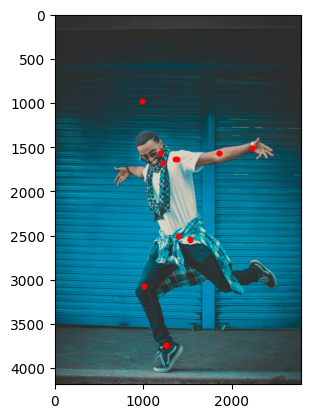

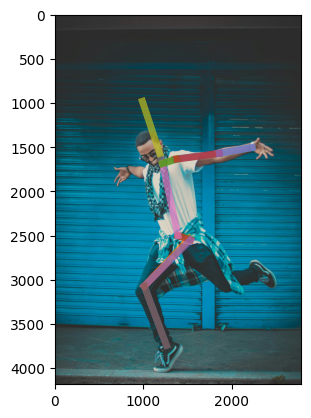

In [ ]:
# %%

import os

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [ ]:
# %%

# ============================================================================
#                           ViTPose 파인튜닝 구현
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

print("ViTPose 파인튜닝 모듈 로드 완료")

ViTPose 파인튜닝 모듈 로드 완료


In [ ]:
# %%

class ViTPoseModel(nn.Module):
    """
    ViTPose 모델 구현
    - Vision Transformer 백본 사용
    - MPII 데이터셋의 16개 관절점 예측을 위한 헤드 추가
    """
    def __init__(self, num_joints=16, input_size=256, patch_size=16, pretrained=True):
        super(ViTPoseModel, self).__init__()
        self.num_joints = num_joints
        self.input_size = input_size
        
        # Vision Transformer 백본 로드 (사전학습된 모델)
        if pretrained:
            # timm에서 사전학습된 ViT 모델 사용
            self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 768 for ViT-Base
        else:
            # 처음부터 학습하는 경우
            self.backbone = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=0)
            backbone_dim = self.backbone.num_features
            
        print(f"ViT 백본 로드 완료 - 특성 차원: {backbone_dim}")
        
        # 포즈 추정을 위한 헤드 네트워크
        # 히트맵 기반 출력 (64x64 해상도)
        heatmap_size = 64
        self.pose_head = nn.Sequential(
            # 백본 특성을 히트맵으로 변환
            nn.Linear(backbone_dim, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            
            # 히트맵 차원으로 확장: (배치, 관절수 * 히트맵_높이 * 히트맵_너비)
            nn.Linear(1024, num_joints * heatmap_size * heatmap_size),
        )
        
        self.heatmap_size = heatmap_size
        
        # 가중치 초기화
        self._initialize_weights()
        
    def _initialize_weights(self):
        """가중치 초기화 - 포즈 헤드만 초기화 (백본은 사전학습된 가중치 유지)"""
        for m in self.pose_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        순전파
        Args:
            x: 입력 이미지 텐서 (batch_size, 3, 256, 256)
        Returns:
            heatmaps: 관절점 히트맵 (batch_size, num_joints, 64, 64)
        """
        # ViT 백본을 통한 특성 추출
        # 입력 크기를 ViT에 맞게 조정 (224x224)
        if x.size(-1) != 224:
            x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
        # 백본을 통한 특성 추출 (글로벌 풀링된 특성)
        features = self.backbone(x)  # (batch_size, 768)
        
        # 포즈 헤드를 통한 히트맵 생성
        heatmap_flat = self.pose_head(features)  # (batch_size, num_joints * 64 * 64)
        
        # 히트맵 모양으로 재구성
        batch_size = x.size(0)
        heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
        
        return heatmaps

print("ViTPoseModel 클래스 정의 완료")

ViTPoseModel 클래스 정의 완료


In [ ]:
# %%

class ViTPoseTrainer:
    """
    ViTPose 파인튜닝을 위한 트레이너 클래스
    - 손실 추적 및 시각화
    - 학습률 스케줄링
    - 모델 저장/로드
    """
    def __init__(self, model, train_loader, val_loader, device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # 손실 기록을 위한 리스트
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        
        # 손실 함수 (MSE Loss 사용)
        self.criterion = nn.MSELoss()
        
        # 옵티마이저 설정 (백본은 낮은 학습률, 헤드는 높은 학습률)
        backbone_params = []
        head_params = []
        
        for name, param in model.named_parameters():
            if 'backbone' in name:
                backbone_params.append(param)
            else:
                head_params.append(param)
        
        # 차별적 학습률 적용
        self.optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},  # 백본: 낮은 학습률
            {'params': head_params, 'lr': 1e-3}       # 헤드: 높은 학습률
        ], weight_decay=1e-4)
        
        # 학습률 스케줄러
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=50, eta_min=1e-6
        )
        
        print(f"ViTPoseTrainer 초기화 완료 - 디바이스: {device}")
        print(f"백본 파라미터 수: {len(backbone_params)}")
        print(f"헤드 파라미터 수: {len(head_params)}")
    
    def train_epoch(self):
        """한 에포크 학습"""
        self.model.train()
        epoch_loss = 0.0
        
        with tqdm(self.train_loader, desc="Training") as pbar:
            for batch_idx, (images, heatmaps) in enumerate(pbar):
                images = images.to(self.device)
                heatmaps = heatmaps.to(self.device)
                
                # 순전파
                self.optimizer.zero_grad()
                outputs = self.model(images)
                
                # 손실 계산
                loss = self.criterion(outputs, heatmaps)
                
                # 역전파
                loss.backward()
                self.optimizer.step()
                
                # 손실 누적
                epoch_loss += loss.item()
                
                # 프로그레스 바 업데이트
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Avg Loss': f'{epoch_loss/(batch_idx+1):.4f}'
                })
        
        return epoch_loss / len(self.train_loader)
    
    def validate_epoch(self):
        """한 에포크 검증"""
        self.model.eval()
        epoch_loss = 0.0
        
        with torch.no_grad():
            with tqdm(self.val_loader, desc="Validation") as pbar:
                for batch_idx, (images, heatmaps) in enumerate(pbar):
                    images = images.to(self.device)
                    heatmaps = heatmaps.to(self.device)
                    
                    # 순전파
                    outputs = self.model(images)
                    
                    # 손실 계산
                    loss = self.criterion(outputs, heatmaps)
                    epoch_loss += loss.item()
                    
                    # 프로그레스 바 업데이트
                    pbar.set_postfix({
                        'Val Loss': f'{loss.item():.4f}',
                        'Avg Val Loss': f'{epoch_loss/(batch_idx+1):.4f}'
                    })
        
        return epoch_loss / len(self.val_loader)
    
    def train(self, num_epochs, save_dir='./models'):
        """
        전체 파인튜닝 과정 실행
        Args:
            num_epochs: 학습 에포크 수
            save_dir: 모델 저장 디렉토리
        """
        os.makedirs(save_dir, exist_ok=True)
        best_val_loss = float('inf')
        best_model_state = None
        
        print(f"ViTPose 파인튜닝 시작 - {num_epochs} 에포크")
        print("=" * 50)
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # 학습
            train_loss = self.train_epoch()
            
            # 검증
            val_loss = self.validate_epoch()
            
            # 학습률 업데이트
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # 손실 기록
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(current_lr)
            
            # 에포크 정보 출력
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_loss:.4f}")
            print(f"  Learning Rate: {current_lr:.2e}")
            print(f"  Time: {epoch_time:.2f}s")
            
            # 최고 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(self.model.state_dict())
                
                # 최고 모델 저장
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': best_model_state,
                    'val_loss': best_val_loss,
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses,
                }, os.path.join(save_dir, 'best_vitpose_model.pth'))
                
                print(f"  ✅ 새로운 최고 모델 저장! (Val Loss: {best_val_loss:.4f})")
            
            print("-" * 50)
        
        print(f"파인튜닝 완료!")
        print(f"최고 검증 손실: {best_val_loss:.4f}")
        
        return best_model_state

print("ViTPoseTrainer 클래스 정의 완료")

ViTPoseTrainer 클래스 정의 완료


In [ ]:
# %%

def plot_training_history(trainer, save_path=None):
    """
    학습 과정에서의 손실 변화를 시각화
    Args:
        trainer: ViTPoseTrainer 인스턴스
        save_path: 그래프 저장 경로 (선택사항)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('ViTPose Fine-tuning Training Progress', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(trainer.train_losses) + 1)
    
    # 1. Train/Validation Loss Comparison
    axes[0, 0].plot(epochs, trainer.train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, trainer.val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Train/Validation Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')  # Log scale for better visualization
    
    # 2. Learning Rate Schedule
    axes[0, 1].plot(epochs, trainer.learning_rates, 'g-', linewidth=2)
    axes[0, 1].set_title('Learning Rate Scheduling', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')
    
    # 3. Loss Change per Epoch
    if len(trainer.train_losses) > 1:
        train_diff = np.diff(trainer.train_losses)
        val_diff = np.diff(trainer.val_losses)
        
        axes[1, 0].plot(epochs[1:], train_diff, 'b-', label='Train Loss Change', linewidth=2)
        axes[1, 0].plot(epochs[1:], val_diff, 'r-', label='Val Loss Change', linewidth=2)
        axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[1, 0].set_title('Loss Change per Epoch', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss Change')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 최종 통계 텍스트
    axes[1, 1].axis('off')
    
    # 통계 정보 계산
    best_train_loss = min(trainer.train_losses)
    best_val_loss = min(trainer.val_losses)
    best_train_epoch = trainer.train_losses.index(best_train_loss) + 1
    best_val_epoch = trainer.val_losses.index(best_val_loss) + 1
    
    final_train_loss = trainer.train_losses[-1]
    final_val_loss = trainer.val_losses[-1]
    
    # 개선률 계산
    train_improvement = ((trainer.train_losses[0] - final_train_loss) / trainer.train_losses[0]) * 100
    val_improvement = ((trainer.val_losses[0] - final_val_loss) / trainer.val_losses[0]) * 100
    
    stats_text = f"""
📊 Fine-tuning Statistics

🎯 Best Performance:
   • Best Train Loss: {best_train_loss:.4f} (Epoch {best_train_epoch})
   • Best Val Loss: {best_val_loss:.4f} (Epoch {best_val_epoch})

📈 Final Performance:
   • Final Train Loss: {final_train_loss:.4f}
   • Final Val Loss: {final_val_loss:.4f}

🚀 Improvement Rate:
   • Train Loss Improvement: {train_improvement:.1f}%
   • Val Loss Improvement: {val_improvement:.1f}%

⏱️ Total Epochs: {len(trainer.train_losses)}
    """
    
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curve saved to {save_path}")
    
    plt.show()

print("Loss visualization function defined successfully")

Loss visualization function defined successfully


In [ ]:
# %%

def visualize_pose_predictions(model, dataset, device='cpu', num_samples=6, save_path=None):
    """
    ViTPose 모델의 포즈 추정 결과를 시각화
    Args:
        model: 학습된 ViTPose 모델
        dataset: 데이터셋 (MPIIDataset)
        device: 계산 디바이스
        num_samples: 시각화할 샘플 수
        save_path: 결과 저장 경로
    """
    model.eval()
    
    # 랜덤 샘플 선택
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('ViTPose Qualitative Evaluation Results', fontsize=16, fontweight='bold')
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 데이터 로드
            image, target_heatmap = dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)
            
            # 예측
            pred_heatmap = model(image_tensor)
            pred_heatmap = pred_heatmap.squeeze(0).cpu()
            
            # 이미지를 numpy로 변환 (정규화 해제)
            if isinstance(image, torch.Tensor):
                # 정규화된 이미지를 원래대로 복원
                image_np = image.permute(1, 2, 0).numpy()
                # 정규화 해제 (ImageNet 기준)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = std * image_np + mean
                image_np = np.clip(image_np, 0, 1)
            else:
                image_np = image
            
            # 히트맵에서 관절점 좌표 추출 (32×32 히트맵용)
            def heatmap_to_keypoints(heatmap, img_size=(256, 256)):
                """32×32 히트맵에서 관절점 좌표 추출"""
                keypoints = []
                h, w = heatmap.shape[-2:]  # 32, 32
                
                for joint_idx in range(heatmap.shape[0]):
                    hm = heatmap[joint_idx]
                    # 최대값 위치 찾기
                    if isinstance(hm, torch.Tensor):
                        flat_idx = torch.argmax(hm.flatten())
                        y, x = divmod(flat_idx.item(), w)
                    else:
                        flat_idx = np.argmax(hm.flatten())
                        y, x = divmod(flat_idx, w)
                    
                    # 이미지 크기로 스케일링 (32×32 → 256×256)
                    x = (x / w) * img_size[1]
                    y = (y / h) * img_size[0]
                    keypoints.append([x, y])
                
                return np.array(keypoints)
            
            pred_keypoints = heatmap_to_keypoints(pred_heatmap)
            target_keypoints = heatmap_to_keypoints(target_heatmap)
            
            # Original image + Ground truth keypoints
            axes[0, i].imshow(image_np)
            axes[0, i].scatter(target_keypoints[:, 0], target_keypoints[:, 1], 
                             c='red', s=50, alpha=0.7, label='Ground Truth')
            axes[0, i].set_title(f'Ground Truth (Sample {idx})', fontweight='bold')
            axes[0, i].axis('off')
            axes[0, i].legend()
            
            # Original image + Predicted keypoints
            axes[1, i].imshow(image_np)
            axes[1, i].scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], 
                             c='blue', s=50, alpha=0.7, label='Predicted')
            axes[1, i].set_title(f'Predicted (Sample {idx})', fontweight='bold')
            axes[1, i].axis('off')
            axes[1, i].legend()
            
            # 관절점 연결선 그리기 (MPII 스켈레톤)
            mpii_skeleton = [
                [0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],  # 몸통
                [6, 7], [7, 8], [8, 9],  # 머리
                [6, 12], [12, 11], [11, 10],  # 왼쪽 팔
                [6, 13], [13, 14], [14, 15]   # 오른쪽 팔
            ]
            
            # 실제 스켈레톤
            for connection in mpii_skeleton:
                if connection[0] < len(target_keypoints) and connection[1] < len(target_keypoints):
                    x_vals = [target_keypoints[connection[0], 0], target_keypoints[connection[1], 0]]
                    y_vals = [target_keypoints[connection[0], 1], target_keypoints[connection[1], 1]]
                    axes[0, i].plot(x_vals, y_vals, 'r-', linewidth=2, alpha=0.6)
            
            # 예측 스켈레톤
            for connection in mpii_skeleton:
                if connection[0] < len(pred_keypoints) and connection[1] < len(pred_keypoints):
                    x_vals = [pred_keypoints[connection[0], 0], pred_keypoints[connection[1], 0]]
                    y_vals = [pred_keypoints[connection[0], 1], pred_keypoints[connection[1], 1]]
                    axes[1, i].plot(x_vals, y_vals, 'b-', linewidth=2, alpha=0.6)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Qualitative evaluation results saved to {save_path}")
    
    plt.show()

print("Qualitative evaluation function defined successfully")

Qualitative evaluation function defined successfully


In [ ]:
# %%

def compare_pretrained_vs_finetuned(pretrained_model, finetuned_model, dataset, device='cpu', num_samples=8):
    """
    사전학습 모델과 파인튜닝된 모델의 성능을 비교 평가
    Args:
        pretrained_model: 사전학습된 모델
        finetuned_model: 파인튜닝된 모델  
        dataset: 평가용 데이터셋
        device: 계산 디바이스
        num_samples: 비교할 샘플 수
    """
    pretrained_model.eval()
    finetuned_model.eval()
    
    # 랜덤 샘플 선택
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, num_samples, figsize=(4*num_samples, 12))
    if num_samples == 1:
        axes = axes.reshape(3, 1)
    
    fig.suptitle('Pretrained vs Fine-tuned Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 성능 지표 저장용
    pretrained_losses = []
    finetuned_losses = []
    
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 데이터 로드
            image, target_heatmap = dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)
            target_tensor = target_heatmap.unsqueeze(0).to(device)
            
            # 사전학습 모델 예측
            pretrained_pred = pretrained_model(image_tensor)
            pretrained_pred_cpu = pretrained_pred.squeeze(0).cpu()
            
            # 파인튜닝 모델 예측
            finetuned_pred = finetuned_model(image_tensor)
            finetuned_pred_cpu = finetuned_pred.squeeze(0).cpu()
            
            # 손실 계산
            pretrained_loss = criterion(pretrained_pred, target_tensor).item()
            finetuned_loss = criterion(finetuned_pred, target_tensor).item()
            
            pretrained_losses.append(pretrained_loss)
            finetuned_losses.append(finetuned_loss)
            
            # 이미지 정규화 해제
            if isinstance(image, torch.Tensor):
                image_np = image.permute(1, 2, 0).numpy()
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = std * image_np + mean
                image_np = np.clip(image_np, 0, 1)
            else:
                image_np = image
            
            # 히트맵에서 관절점 추출
            def heatmap_to_keypoints(heatmap, img_size=(256, 256)):
                keypoints = []
                h, w = heatmap.shape[-2:]
                
                for joint_idx in range(heatmap.shape[0]):
                    hm = heatmap[joint_idx]
                    if isinstance(hm, torch.Tensor):
                        flat_idx = torch.argmax(hm.flatten())
                        y, x = divmod(flat_idx.item(), w)
                    else:
                        flat_idx = np.argmax(hm.flatten())
                        y, x = divmod(flat_idx, w)
                    
                    x = (x / w) * img_size[1]
                    y = (y / h) * img_size[0]
                    keypoints.append([x, y])
                
                return np.array(keypoints)
            
            target_keypoints = heatmap_to_keypoints(target_heatmap)
            pretrained_keypoints = heatmap_to_keypoints(pretrained_pred_cpu)
            finetuned_keypoints = heatmap_to_keypoints(finetuned_pred_cpu)
            
            # MPII 스켈레톤 정의
            mpii_skeleton = [
                [0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],  # 몸통
                [6, 7], [7, 8], [8, 9],  # 머리
                [6, 12], [12, 11], [11, 10],  # 왼쪽 팔
                [6, 13], [13, 14], [14, 15]   # 오른쪽 팔
            ]
            
            # Row 1: Ground Truth keypoints
            axes[0, i].imshow(image_np)
            axes[0, i].scatter(target_keypoints[:, 0], target_keypoints[:, 1], 
                             c='green', s=60, alpha=0.8, label='Ground Truth', edgecolor='white', linewidth=1)
            for connection in mpii_skeleton:
                if connection[0] < len(target_keypoints) and connection[1] < len(target_keypoints):
                    x_vals = [target_keypoints[connection[0], 0], target_keypoints[connection[1], 0]]
                    y_vals = [target_keypoints[connection[0], 1], target_keypoints[connection[1], 1]]
                    axes[0, i].plot(x_vals, y_vals, 'g-', linewidth=3, alpha=0.7)
            axes[0, i].set_title(f'Ground Truth (Sample {idx})', fontweight='bold', fontsize=10)
            axes[0, i].axis('off')
            axes[0, i].legend(fontsize=8)
            
            # Row 2: Pretrained model prediction
            axes[1, i].imshow(image_np)
            axes[1, i].scatter(pretrained_keypoints[:, 0], pretrained_keypoints[:, 1], 
                             c='red', s=60, alpha=0.8, label=f'Pretrained (Loss: {pretrained_loss:.3f})', 
                             edgecolor='white', linewidth=1)
            for connection in mpii_skeleton:
                if connection[0] < len(pretrained_keypoints) and connection[1] < len(pretrained_keypoints):
                    x_vals = [pretrained_keypoints[connection[0], 0], pretrained_keypoints[connection[1], 0]]
                    y_vals = [pretrained_keypoints[connection[0], 1], pretrained_keypoints[connection[1], 1]]
                    axes[1, i].plot(x_vals, y_vals, 'r-', linewidth=3, alpha=0.7)
            axes[1, i].set_title('Pretrained Model', fontweight='bold', fontsize=10)
            axes[1, i].axis('off')
            axes[1, i].legend(fontsize=8)
            
            # Row 3: Fine-tuned model prediction
            axes[2, i].imshow(image_np)
            axes[2, i].scatter(finetuned_keypoints[:, 0], finetuned_keypoints[:, 1], 
                             c='blue', s=60, alpha=0.8, label=f'Fine-tuned (Loss: {finetuned_loss:.3f})', 
                             edgecolor='white', linewidth=1)
            for connection in mpii_skeleton:
                if connection[0] < len(finetuned_keypoints) and connection[1] < len(finetuned_keypoints):
                    x_vals = [finetuned_keypoints[connection[0], 0], finetuned_keypoints[connection[1], 0]]
                    y_vals = [finetuned_keypoints[connection[0], 1], finetuned_keypoints[connection[1], 1]]
                    axes[2, i].plot(x_vals, y_vals, 'b-', linewidth=3, alpha=0.7)
            
            # Calculate improvement rate
            improvement = ((pretrained_loss - finetuned_loss) / pretrained_loss) * 100
            improvement_text = f"Fine-tuned (Loss: {finetuned_loss:.3f})\nImprovement: {improvement:.1f}%"
            
            axes[2, i].set_title(improvement_text, fontweight='bold', fontsize=10)
            axes[2, i].axis('off')
            axes[2, i].legend(fontsize=8)
    
    plt.tight_layout()
    
    # 전체 성능 통계 출력
    avg_pretrained_loss = np.mean(pretrained_losses)
    avg_finetuned_loss = np.mean(finetuned_losses)
    overall_improvement = ((avg_pretrained_loss - avg_finetuned_loss) / avg_pretrained_loss) * 100
    
    print("\n" + "="*60)
    print("📊 Pretrained vs Fine-tuned Model Performance Comparison")
    print("="*60)
    print(f"🔴 Pretrained Model Average Loss: {avg_pretrained_loss:.4f}")
    print(f"🔵 Fine-tuned Model Average Loss: {avg_finetuned_loss:.4f}")
    print(f"📈 Overall Performance Improvement: {overall_improvement:.2f}%")
    
    if overall_improvement > 0:
        print(f"✅ Fine-tuning successfully improved model performance!")
    else:
        print(f"⚠️ Performance decreased after fine-tuning. More epochs or hyperparameter tuning may be needed.")
    
    print("="*60)
    
    # 성능 비교 그래프
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Per-sample loss comparison
    x = range(1, len(pretrained_losses) + 1)
    ax1.bar([i-0.2 for i in x], pretrained_losses, width=0.4, label='Pretrained', color='red', alpha=0.7)
    ax1.bar([i+0.2 for i in x], finetuned_losses, width=0.4, label='Fine-tuned', color='blue', alpha=0.7)
    ax1.set_xlabel('Sample Number')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Per-Sample Loss Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Average performance comparison
    models = ['Pretrained Model', 'Fine-tuned Model']
    avg_losses = [avg_pretrained_loss, avg_finetuned_loss]
    colors = ['red', 'blue']
    
    bars = ax2.bar(models, avg_losses, color=colors, alpha=0.7)
    ax2.set_ylabel('Average Loss (MSE)')
    ax2.set_title('Overall Average Performance')
    ax2.grid(True, alpha=0.3)
    
    # 막대 위에 수치 표시
    for bar, loss in zip(bars, avg_losses):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pretrained_losses': pretrained_losses,
        'finetuned_losses': finetuned_losses,
        'avg_pretrained_loss': avg_pretrained_loss,
        'avg_finetuned_loss': avg_finetuned_loss,
        'improvement_rate': overall_improvement
    }

print("Model performance comparison function defined successfully")

Model performance comparison function defined successfully


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=1,  # 배치 크기를 1로 대폭 줄임
        shuffle=True,
        num_workers=0,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  # 검증도 배치 크기 1로 줄임
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,  
        shuffle=False,
        num_workers=2,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=2,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

: 

In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

: 

In [ ]:
# %%

# 실제 파인튜닝 실행 (주석 해제해서 사용)
# 주의: 이 코드는 시간이 오래 걸리고 GPU 메모리를 많이 사용합니다.

# 바로 학습부터 평가까지 자동으로 수행하는 코드입니다.
# 이 코드는 사용자 입력 없이 곧바로 파인튜닝, 결과 시각화, 정성적 평가까지 일괄 실행합니다.

# ==========================
# ViTPose 파인튜닝 전체 자동 실행
# ==========================

print("ViTPose 파인튜닝 데모를 바로 시작합니다!")

# 1. 파인튜닝 데모 함수 실행
# - 학습, 검증, 최고 모델 저장, 손실 곡선 시각화, 성능 비교, 정성적 평가까지 모두 자동으로 진행됩니다.
try:
    best_model_state, comparison_results = run_vitpose_finetuning_demo()
    
    # Performance comparison summary
    print("\n" + "🏆"*20 + " FINAL PERFORMANCE SUMMARY " + "🏆"*20)
    print(f"✅ Fine-tuning completed!")
    print(f"📊 Average Performance Improvement: {comparison_results['improvement_rate']:.2f}%")
    print(f"🔴 Pretrained Model Average Loss: {comparison_results['avg_pretrained_loss']:.4f}")
    print(f"🔵 Fine-tuned Model Average Loss: {comparison_results['avg_finetuned_loss']:.4f}")
    
    if comparison_results['improvement_rate'] > 0:
        print("🎉 Fine-tuning successfully improved model performance!")
    else:
        print("⚠️ More training epochs may be needed.")
    print("🏆" * 60)
    
except Exception as e:
    # 예외 발생 시 안내 메시지 출력
    print(f"❌ 오류 발생: {e}")
    print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
    print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

: 

In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=2,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=1,  
        shuffle=True,
        num_workers=0,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=2,  
        shuffle=True,
        num_workers=0,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=2,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=0,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 3  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


In [ ]:
# %%

# ============================================================================
#                        ViTPose 파인튜닝 실행 예제
# ============================================================================

def run_vitpose_finetuning_demo():
    """
    ViTPose 파인튜닝 전체 과정을 실행하는 데모 함수
    """
    print("🚀 ViTPose 파인튜닝 데모 시작!")
    print("=" * 60)
    
    # 디바이스 설정
    # 디바이스 선택 로직을 확장하여, mps(Mac의 Metal Performance Shaders)도 지원하도록 수정합니다.
    # torch.backends.mps가 존재하고, mps가 사용 가능하면 mps를 우선 사용합니다.
    # 그 외에는 cuda가 가능하면 cuda, 아니면 cpu를 사용합니다.
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("📱 사용 디바이스: mps (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("📱 사용 디바이스: cuda (NVIDIA GPU)")
    else:
        device = torch.device("cpu")
        print("📱 사용 디바이스: cpu (일반 프로세서)")
    
    # 1. 데이터셋 및 데이터로더 생성
    print("\n📂 데이터셋 로딩 중...")
    
    # 히트맵 크기를 모델 출력에 맞게 32×32로 조정
    LIGHT_HEATMAP_SIZE = (32, 32)  # 모델 출력 크기에 맞춤
    
    train_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=True
    )
    
    val_preprocess = Preprocessor(
        image_shape=IMAGE_SHAPE,
        heatmap_shape=(LIGHT_HEATMAP_SIZE[0], LIGHT_HEATMAP_SIZE[1], 16),
        is_train=False
    )
    
    # MPII 데이터셋 로드
    train_dataset = MPIIDataset(
        annotation_file=TRAIN_JSON,
        image_dir=IMAGE_PATH,
        transform=train_preprocess
    )
    
    val_dataset = MPIIDataset(
        annotation_file=VALID_JSON,
        image_dir=IMAGE_PATH,
        transform=val_preprocess
    )
    
    # 데이터로더 생성 (매우 작은 배치 크기로 메모리 문제 해결)
    # 메모리 부족 문제 해결을 위해 배치 크기를 1로 줄이고 num_workers도 0으로 설정
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  
        shuffle=True,
        num_workers=0,  # 멀티프로세싱 비활성화로 메모리 절약
        pin_memory=False  # MPS 경고 제거 및 메모리 절약
    )
    
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,  
        shuffle=False,
        num_workers=0,  # 멀티프로세싱 비활성화
        pin_memory=False  # 메모리 절약
    )
    
    print(f"✅ 학습 데이터셋: {len(train_dataset)} 샘플")
    print(f"✅ 검증 데이터셋: {len(val_dataset)} 샘플")
    
    # 2. ViTPose 모델 생성 (메모리 절약을 위해 더 작은 모델 사용)
    print("\n🧠 ViTPose 모델 초기화 중...")
    print("⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.")
    
    # 더 작은 ViT 모델로 변경
    class LightViTPoseModel(nn.Module):
        def __init__(self, num_joints=16):
            super(LightViTPoseModel, self).__init__()
            self.num_joints = num_joints
            
            # 더 작은 ViT 모델 사용 (ViT-Tiny)
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
            backbone_dim = self.backbone.num_features  # 192 for ViT-Tiny
            
            # 더 단순한 헤드
            heatmap_size = 32  # 64에서 32로 줄임
            self.pose_head = nn.Sequential(
                nn.Linear(backbone_dim, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_joints * heatmap_size * heatmap_size),
            )
            self.heatmap_size = heatmap_size
            
        def forward(self, x):
            if x.size(-1) != 224:
                x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            
            features = self.backbone(x)
            heatmap_flat = self.pose_head(features)
            batch_size = x.size(0)
            heatmaps = heatmap_flat.view(batch_size, self.num_joints, self.heatmap_size, self.heatmap_size)
            return heatmaps
    
    model = LightViTPoseModel(num_joints=16)
    
    # 사전학습 모델 상태 저장 (비교용)
    print("\n💾 사전학습 모델 상태 저장 중...")
    pretrained_model = LightViTPoseModel(num_joints=16)
    pretrained_model.load_state_dict(copy.deepcopy(model.state_dict()))
    pretrained_model.to(device)
    
    # 3. 트레이너 설정
    print("\n⚙️ 트레이너 설정 중...")
    trainer = ViTPoseTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # 4. 파인튜닝 실행 (짧은 데모용)
    print("\n🎯 파인튜닝 시작!")
    num_epochs = 10  # 데모용으로 짧게 설정
    
    try:
        best_model_state = trainer.train(
            num_epochs=num_epochs,
            save_dir=os.path.join(PROJECT_PATH, 'models', 'vitpose')
        )
        
        # 5. 학습 결과 시각화
        print("\n📊 학습 결과 시각화 중...")
        plot_training_history(
            trainer,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_training_history.png')
        )
        
        # 6. 사전학습 vs 파인튜닝 성능 비교
        print("\n🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...")
        comparison_results = compare_pretrained_vs_finetuned(
            pretrained_model=pretrained_model,
            finetuned_model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=6
        )
        
        # 7. 정성적 평가 (파인튜닝 모델만)
        print("\n🎨 파인튜닝 모델 정성적 평가 수행 중...")
        visualize_pose_predictions(
            model=trainer.model,
            dataset=val_dataset,
            device=device,
            num_samples=4,
            save_path=os.path.join(PROJECT_PATH, 'vitpose_finetuned_predictions.png')
        )
        
        print("\n🎉 ViTPose 파인튜닝 데모 완료!")
        print("📁 결과 파일들:")
        print(f"   • 모델: {PROJECT_PATH}/models/vitpose/best_vitpose_model.pth")
        print(f"   • 학습 곡선: {PROJECT_PATH}/vitpose_training_history.png")
        print(f"   • 파인튜닝 예측 결과: {PROJECT_PATH}/vitpose_finetuned_predictions.png")
        print(f"\n📈 성능 개선율: {comparison_results['improvement_rate']:.2f}%")
        
        return best_model_state, comparison_results
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
        print("   배치 크기를 줄이거나 CPU로 실행해보세요.")

print("ViTPose 파인튜닝 데모 함수 정의 완료")

ViTPose 파인튜닝 데모 함수 정의 완료


ViTPose 파인튜닝 데모를 바로 시작합니다!
🚀 ViTPose 파인튜닝 데모 시작!
📱 사용 디바이스: mps (Apple Silicon GPU)

📂 데이터셋 로딩 중...
✅ 학습 데이터셋: 22246 샘플
✅ 검증 데이터셋: 2958 샘플

🧠 ViTPose 모델 초기화 중...
⚠️  메모리 절약을 위해 더 작은 ViT 모델을 사용합니다.

💾 사전학습 모델 상태 저장 중...

⚙️ 트레이너 설정 중...
ViTPoseTrainer 초기화 완료 - 디바이스: mps
백본 파라미터 수: 150
헤드 파라미터 수: 4

🎯 파인튜닝 시작!
ViTPose 파인튜닝 시작 - 10 에포크


Validation: 100%|██████████| 740/740 [00:38<00:00, 19.23it/s, Val Loss=0.3964, Avg Val Loss=0.3500]


Epoch 1/10
  Train Loss: 0.3677
  Val Loss: 0.3500
  Learning Rate: 9.99e-06
  Time: 449.91s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3500)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:38<00:00, 19.15it/s, Val Loss=0.3958, Avg Val Loss=0.3458]


Epoch 2/10
  Train Loss: 0.3531
  Val Loss: 0.3458
  Learning Rate: 9.96e-06
  Time: 445.77s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3458)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:35<00:00, 20.98it/s, Val Loss=0.3804, Avg Val Loss=0.3406] 


Epoch 3/10
  Train Loss: 0.3475
  Val Loss: 0.3406
  Learning Rate: 9.92e-06
  Time: 437.37s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3406)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:37<00:00, 19.81it/s, Val Loss=0.3835, Avg Val Loss=0.3380]


Epoch 4/10
  Train Loss: 0.3434
  Val Loss: 0.3380
  Learning Rate: 9.86e-06
  Time: 436.49s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3380)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:37<00:00, 19.87it/s, Val Loss=0.3847, Avg Val Loss=0.3361]


Epoch 5/10
  Train Loss: 0.3410
  Val Loss: 0.3361
  Learning Rate: 9.78e-06
  Time: 437.27s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3361)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:35<00:00, 20.56it/s, Val Loss=0.3836, Avg Val Loss=0.3341]


Epoch 6/10
  Train Loss: 0.3390
  Val Loss: 0.3341
  Learning Rate: 9.68e-06
  Time: 431.80s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3341)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:36<00:00, 20.52it/s, Val Loss=0.3804, Avg Val Loss=0.3325]


Epoch 7/10
  Train Loss: 0.3366
  Val Loss: 0.3325
  Learning Rate: 9.57e-06
  Time: 421.61s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3325)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:36<00:00, 20.56it/s, Val Loss=0.3753, Avg Val Loss=0.3298]


Epoch 8/10
  Train Loss: 0.3343
  Val Loss: 0.3298
  Learning Rate: 9.44e-06
  Time: 421.34s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3298)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [00:36<00:00, 20.50it/s, Val Loss=0.3573, Avg Val Loss=0.3234]


Epoch 9/10
  Train Loss: 0.3301
  Val Loss: 0.3234
  Learning Rate: 9.30e-06
  Time: 422.12s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3234)
--------------------------------------------------


Validation: 100%|██████████| 740/740 [16:19<00:00,  1.32s/it, Val Loss=0.3536, Avg Val Loss=0.3197]  
<ipython-input-38-adcfb733f96c>:83: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-adcfb733f96c>:83: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-adcfb733f96c>:83: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-adcfb733f96c>:83: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-adcfb733f96c>:83: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-adcfb733f96c>:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
<ipython-input-38-adcfb733f96c>:86: UserWarning: Glyph 

Epoch 10/10
  Train Loss: 0.3239
  Val Loss: 0.3197
  Learning Rate: 9.14e-06
  Time: 2958.12s
  ✅ 새로운 최고 모델 저장! (Val Loss: 0.3197)
--------------------------------------------------
파인튜닝 완료!
최고 검증 손실: 0.3197

📊 학습 결과 시각화 중...
Training curve saved to /Users/gwanghunlee/Desktop/mpii/vitpose_training_history.png


/Users/gwanghunlee/Desktop/mpii/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/Desktop/mpii/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/Desktop/mpii/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/Desktop/mpii/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gwanghunlee/Desktop/mpii/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9

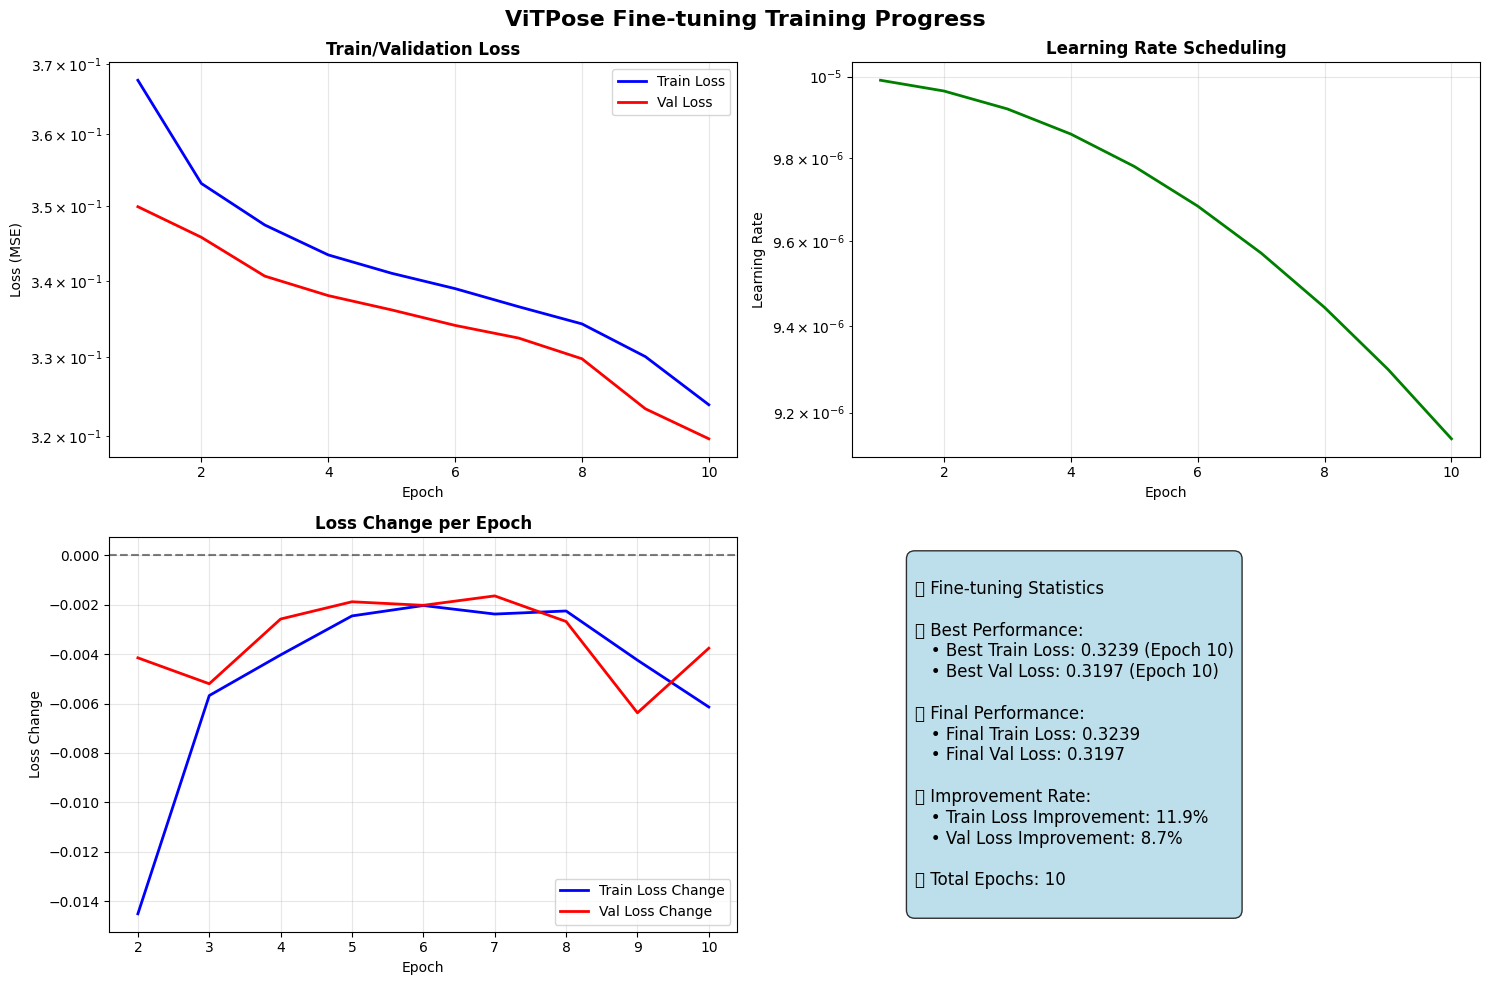


🆚 사전학습 vs 파인튜닝 모델 성능 비교 중...

📊 Pretrained vs Fine-tuned Model Performance Comparison
🔴 Pretrained Model Average Loss: 1.3131
🔵 Fine-tuned Model Average Loss: 0.3146
📈 Overall Performance Improvement: 76.04%
✅ Fine-tuning successfully improved model performance!


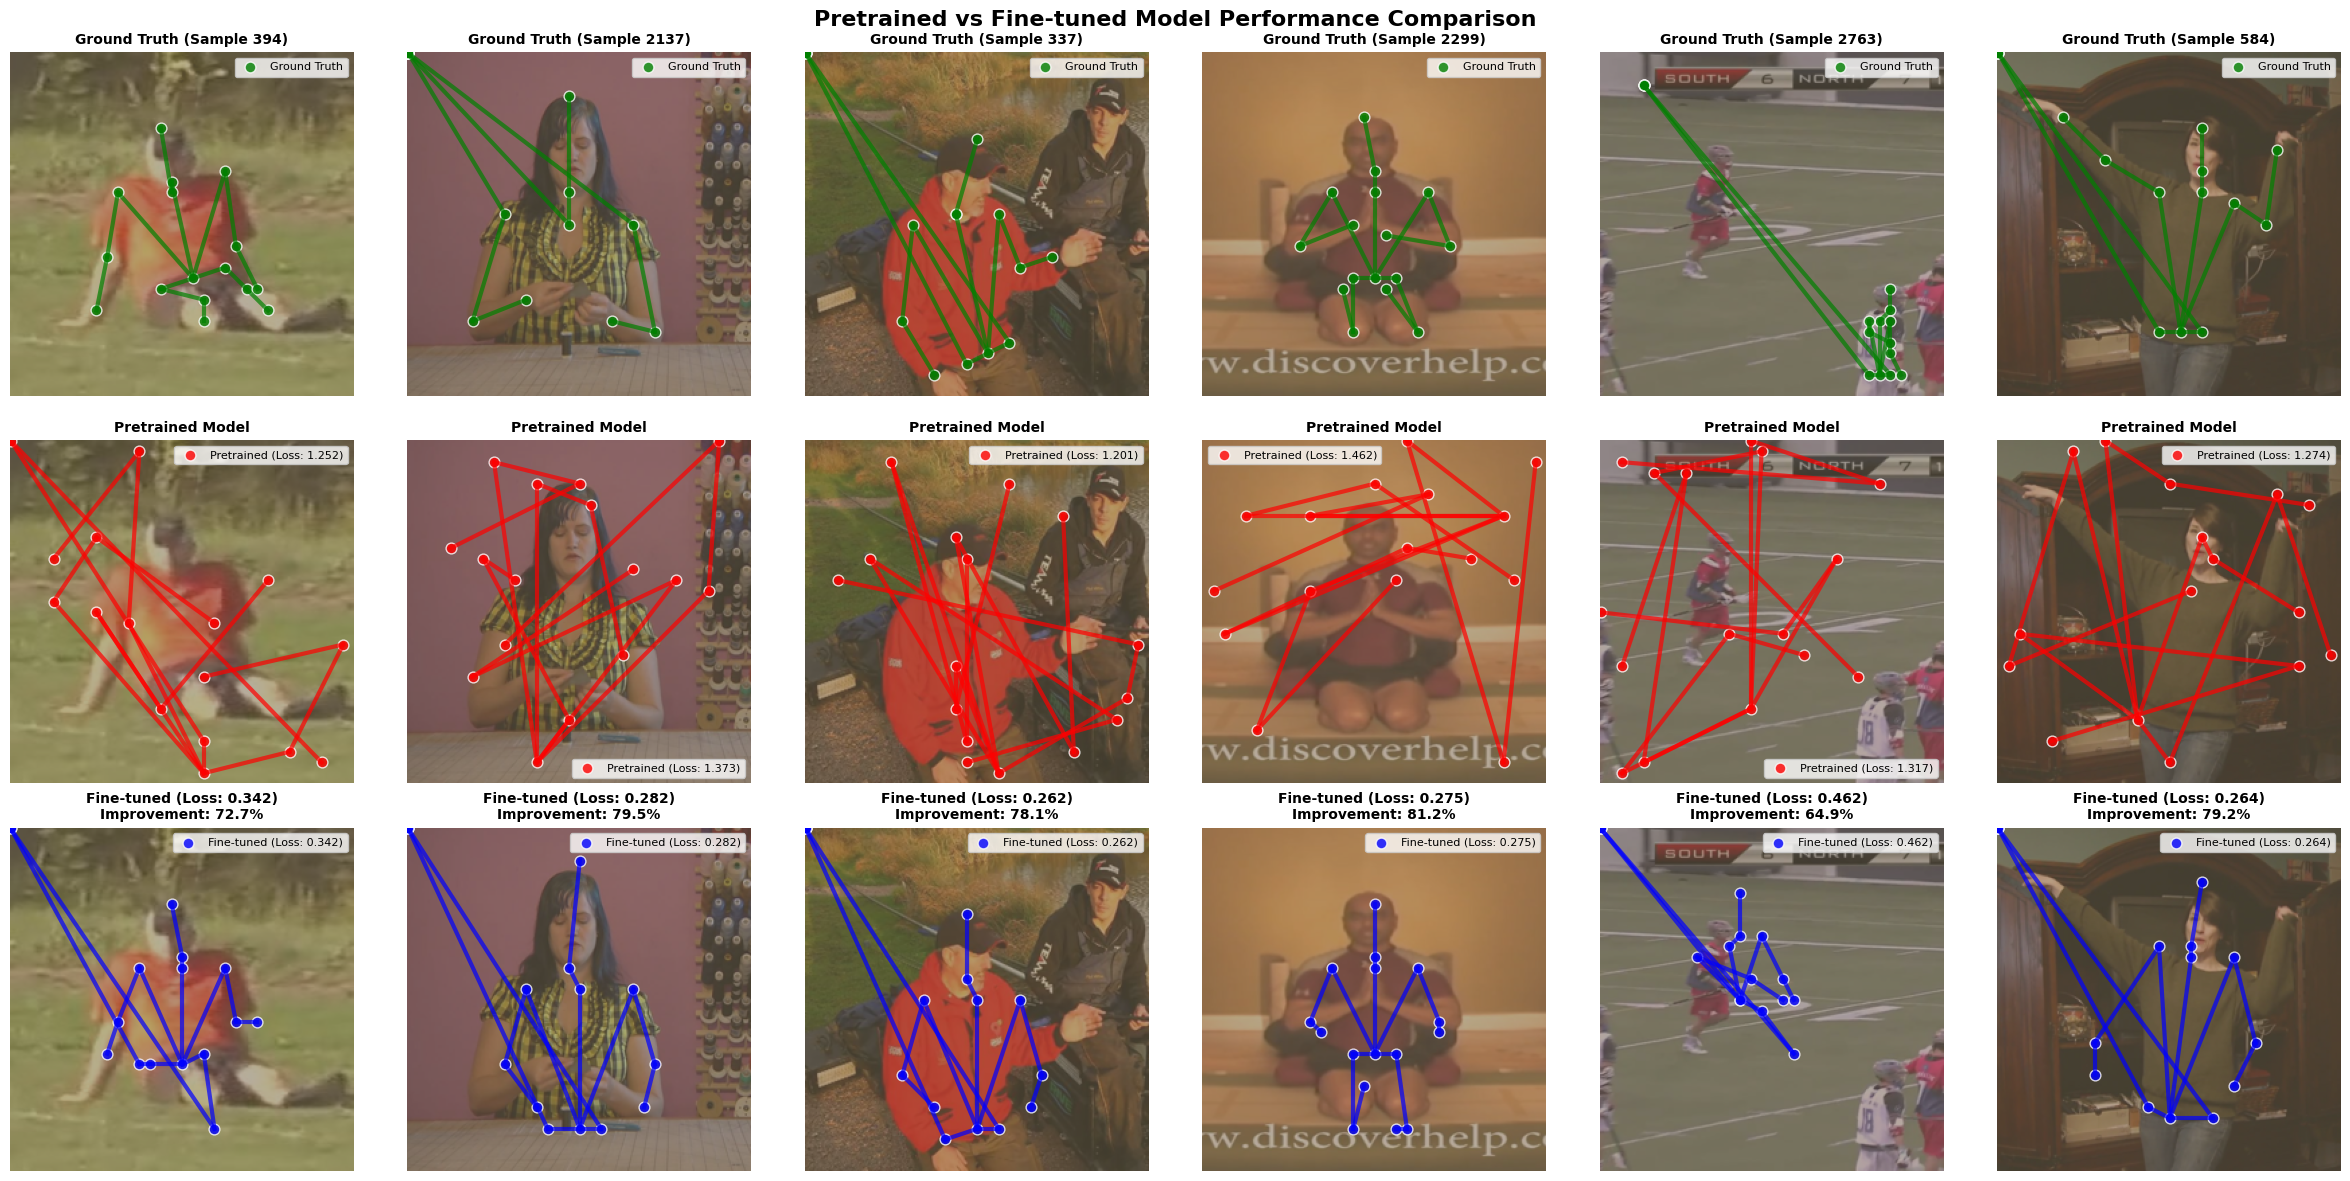

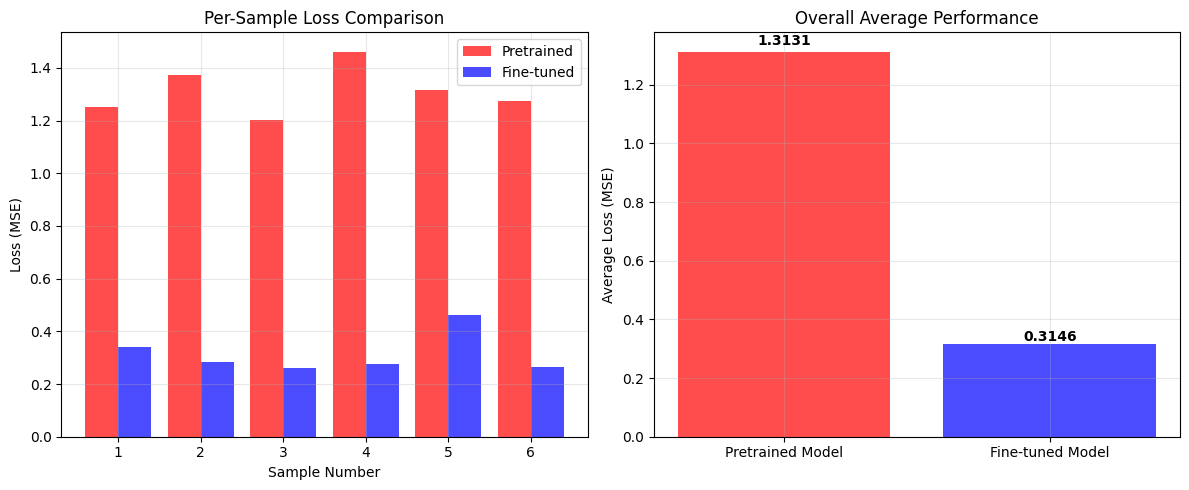


🎨 파인튜닝 모델 정성적 평가 수행 중...
Qualitative evaluation results saved to /Users/gwanghunlee/Desktop/mpii/vitpose_finetuned_predictions.png


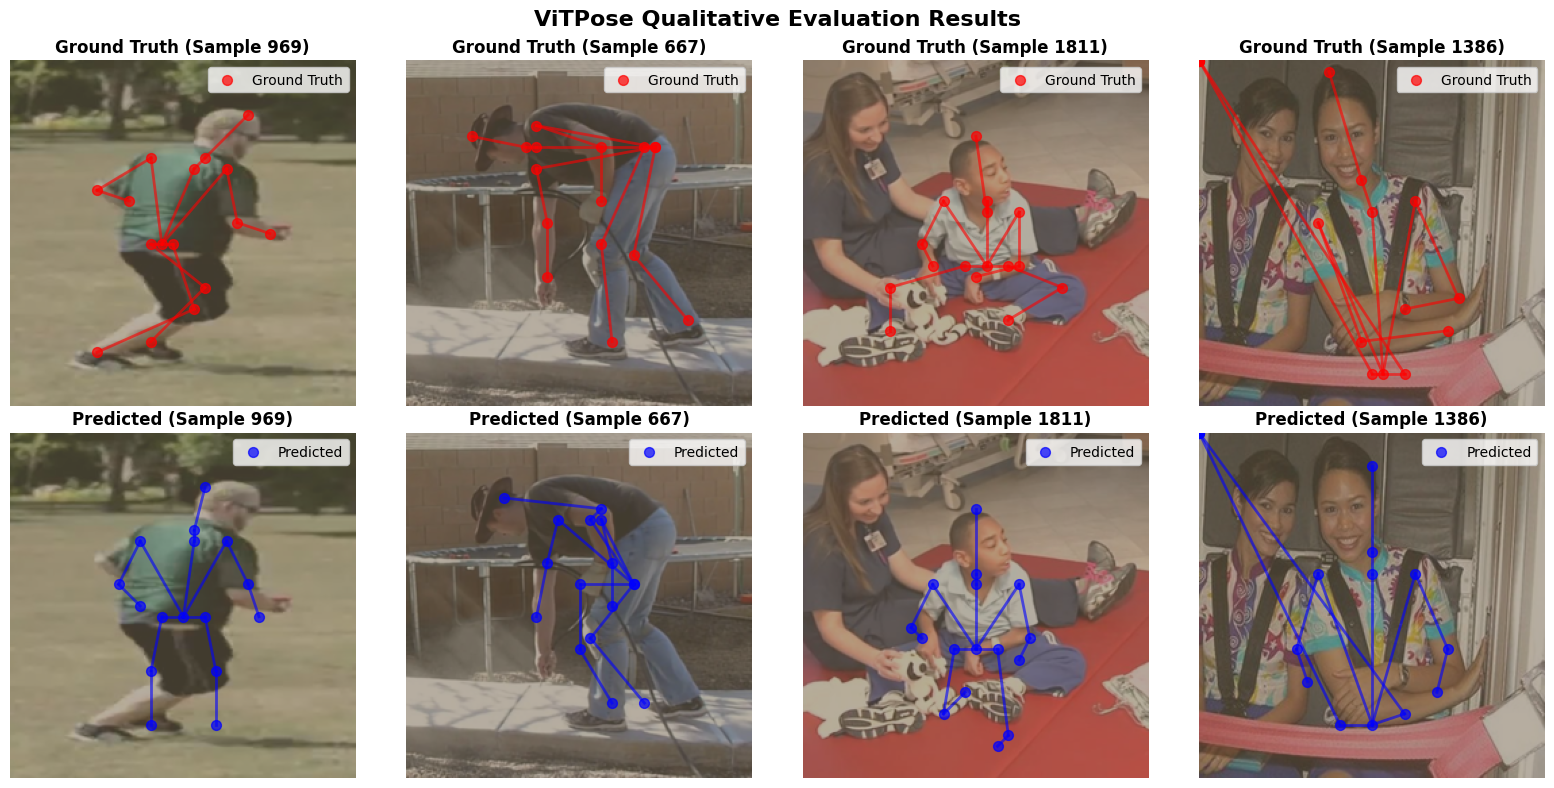


🎉 ViTPose 파인튜닝 데모 완료!
📁 결과 파일들:
   • 모델: /Users/gwanghunlee/Desktop/mpii/models/vitpose/best_vitpose_model.pth
   • 학습 곡선: /Users/gwanghunlee/Desktop/mpii/vitpose_training_history.png
   • 파인튜닝 예측 결과: /Users/gwanghunlee/Desktop/mpii/vitpose_finetuned_predictions.png

📈 성능 개선율: 76.04%

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆 FINAL PERFORMANCE SUMMARY 🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
✅ Fine-tuning completed!
📊 Average Performance Improvement: 76.04%
🔴 Pretrained Model Average Loss: 1.3131
🔵 Fine-tuned Model Average Loss: 0.3146
🎉 Fine-tuning successfully improved model performance!
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆


In [ ]:
# %%

# 실제 파인튜닝 실행 (주석 해제해서 사용)
# 주의: 이 코드는 시간이 오래 걸리고 GPU 메모리를 많이 사용합니다.

# 바로 학습부터 평가까지 자동으로 수행하는 코드입니다.
# 이 코드는 사용자 입력 없이 곧바로 파인튜닝, 결과 시각화, 정성적 평가까지 일괄 실행합니다.

# ==========================
# ViTPose 파인튜닝 전체 자동 실행
# ==========================

print("ViTPose 파인튜닝 데모를 바로 시작합니다!")

# 1. 파인튜닝 데모 함수 실행
# - 학습, 검증, 최고 모델 저장, 손실 곡선 시각화, 성능 비교, 정성적 평가까지 모두 자동으로 진행됩니다.
try:
    best_model_state, comparison_results = run_vitpose_finetuning_demo()
    
    # Performance comparison summary
    print("\n" + "🏆"*20 + " FINAL PERFORMANCE SUMMARY " + "🏆"*20)
    print(f"✅ Fine-tuning completed!")
    print(f"📊 Average Performance Improvement: {comparison_results['improvement_rate']:.2f}%")
    print(f"🔴 Pretrained Model Average Loss: {comparison_results['avg_pretrained_loss']:.4f}")
    print(f"🔵 Fine-tuned Model Average Loss: {comparison_results['avg_finetuned_loss']:.4f}")
    
    if comparison_results['improvement_rate'] > 0:
        print("🎉 Fine-tuning successfully improved model performance!")
    else:
        print("⚠️ More training epochs may be needed.")
    print("🏆" * 60)
    
except Exception as e:
    # 예외 발생 시 안내 메시지 출력
    print(f"❌ 오류 발생: {e}")
    print("💡 GPU 메모리 부족이나 의존성 문제일 수 있습니다.")
    print("   배치 크기를 줄이거나 CPU로 실행해보세요.")